# How Competitive are Health Insurance Marketplaces?

Since 2014, with the Affordable Care Act (ACA), individuals without access to health care insurance through employment, can purchase in the Health Insurance Marketplace. The system was created to define a set of minimum coverage standards at affordable cost, aiming to widely expand access to health insurance. The mechanism to achieve this relies on a set of regulations placed on insurers and on market competition. The question we explore here is, are these markets competitive?

In this notes we limit the analysis to the observed final result: how many options an individual faces when choosing health insurance in the Insurance Exchange Marketplace, where plans offer certain guarantees in terms of coverage and premiums. 

We take a look at all health insurance plans being offered in the US in 2018 through the federally facilitated market place. There are 39 states under the federal program. An individual will have access to the plans offered in the area they live (offered in their county). We compute the number of plans being offered in each FIPS county code area on those states and use it as a measure of the level of competition in that market. Further, we look at the distribution of the number of plans offered, and explore correlations with geographic area characteristics. Relevant factors to consider in explaining these measures are state, population size, unemployment level, number of health professionals or health facilities available in the area, population age and population income, among other variables.

In [1]:
# Import libraries 
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 60)

In [3]:
# Set Printing Options
font = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12}

## Federally Facilitated Marketplace Plans in 2018 by FIPS

### The Data
The file plans_ahrf has summary information on plans offered under the ACA individual isurance markets. It only includes federally mandated markets. The file includes for each county (CBSA or FIPS) the following measures:
* Premium_30, count - count of different plans offered,
* Issuer_ID, nunique - number of different insurance companies offereing plans,
* Premium_XX, mean - average perimium for multiple age groups
* Pop2017 - County population in 2017 (from AHRF)
* MedIncome2017 - County median income in 2017 (from AHRF)
* IndMarketEnroll2017 - Number of individuals enrolled in a health insurance plan though the individual marketplace in 2017 (from AHRF)
* Unemployment - County unemployment rate (from AHRF)

Other variables include:
* fips_st - Fips state code
* fips_county - Fips_county

Data sources:

(1) 2018 QHP landscape data downloaded from https://www.healthcare.gov/health-plan-information-2018/

(2) Area resource health file downloaded from https://data.hrsa.gov/data/download


### The Market
The analysis is limited to the states running under the federal government in 2018, and the set of qualified health plans (QHP) offered. Some states, like California with Covered California, chose to run their own Marketplace. The original file has 39,348 rows and a large number of columns. We only read in a subset of columns, containing plan identification variables, plan type, geographic area where offered (at the FIPS County Code Level), and plan premiums, a total of 26 columns. The database cover 39 states: AK, AL, FL, AR, AZ, DE, GA, IL, MI, HI, MO, IA, IN, MS, KS, KY, LA, ME, MT, PA, ND, NJ, NE, NM, NH, NC, OR, WI, NV, OH, OK, SD, SC, VA, TX, TN, UT, WV, WY. The number of total distinct plans offered is 2,722.

Depending on the generosity of the plan it will belong to one of the potentially many tiers available (the main ones being bronze, silver, and gold). Since one inssurer may offered more than one plan, we also caclulate the number of issurers in each county as a second measure of competition. 

In [4]:
plans_ahrf = (pd.read_json("./plans_ahrf.json"))

In [5]:
print(plans_ahrf.describe())

               fips  count_plans  count_issuers      fips_st  fips_county  \
count   2718.000000  2718.000000    2718.000000  2718.000000  2718.000000   
mean   31341.718543    14.461737       1.710817    31.231052   110.666299   
std    14959.243238    10.564618       1.004719    14.940994   112.382540   
min     1001.000000     2.000000       1.000000     1.000000     1.000000   
25%    19135.500000     7.000000       1.000000    19.000000    39.000000   
50%    31014.000000    12.000000       1.000000    31.000000    85.000000   
75%    46092.500000    18.000000       2.000000    46.000000   143.000000   
max    56045.000000   119.000000       7.000000    56.000000   840.000000   

               CBSA     CBSA_Ind       Pop2017  MedIncome2017  \
count   1556.000000  2718.000000  2.718000e+03    2718.000000   
mean   29454.435090     0.784032  8.356875e+04   49715.470935   
std    11404.863815     0.769837  2.429608e+05   12603.786716   
min    10100.000000     0.000000  2.960000e+02

## Plan Options Distribution

The number of plans offered accros all counties participated in the federally mandated markets ranges from 2 to 119, with an average number of 14 plans, and a median of 12 plans. The distribution is concentrated in the lower end of the distribution with an interquartile range of 11. Half of the counties offered a number of plans between 7 and 18. In order to factor the size of each geographic area, and reflect the options faced by all individuals in those areas we use the 2017 enrollment in these markets to evaluate this distribution. Fig 1 shows the distribution of the number of options faced by individuals in this market.

However, many of these plans target different individuals and they may be offered by the same insurance company (issurer). Taking this into account, we can look at the number of issuers participating in each area. The options now are highly reduced. The number of issuers range from 1 to 7, with 75% of the areas having one or two participants. Fig 2 shows the distribution of number of issuer optons faced by individuals in this market.

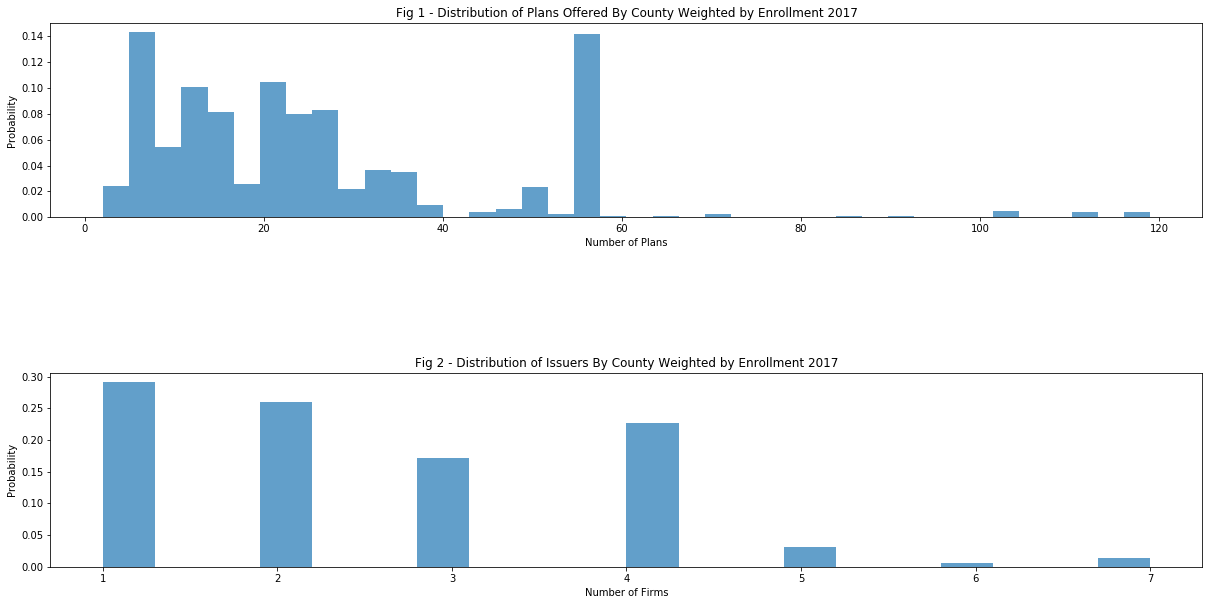

<Figure size 432x288 with 0 Axes>

In [11]:
# How many plans/issuers individuals face?
# we use last year's market size to weight number of plans per FIP codes.
# change to seaborn
plt.figure(figsize=(20,10))
wgt = plans_ahrf['IndMarketEnroll2017']/np.sum(plans_ahrf['IndMarketEnroll2017'])

plt.subplot(211)
plt.hist(plans_ahrf['count_plans'],bins=40, weights=wgt, alpha=0.7)
plt.title("Fig 1 - Distribution of Plans Offered By County Weighted by Enrollment 2017")
plt.xlabel("Number of Plans")
plt.ylabel("Probability")

plt.subplot(212)
plt.hist(plans_ahrf['count_issuers'], bins=20, weights=wgt, alpha=0.7)
plt.title("Fig 2 - Distribution of Issuers By County Weighted by Enrollment 2017")
plt.xlabel("Number of Firms")
plt.ylabel("Probability")

plt.subplots_adjust(left=0.1, right=0.9 ,hspace=0.8)
plt.show()
plt.savefig("figures 1 and 2.png")

The distribution of the number of plans available varies widely across states. Median number of plans offered by state ranges from 4 to 36. Among states offering larger options we see Florida and Wisconsin. In the lower end we see Alaska, Arizona, Mississippi and Iowa. This results suggests that even under federally mandated states, probably state regulations have an effect in these markets. See Fig. 3

We look at scatter plots and correlations between the number of plans offered on each geographic area in 2018, and the total population in the area in 2017, the total enrollment in the Health Insurance Market in 2017, the unemployment rate. There seems to be a small positive correlation between the number of plans and market enrollment in the previous year (0.27), and the number of plans and population size (0.25). 

We could test the predictive power of State, market enrollment in the previous year and population size. 

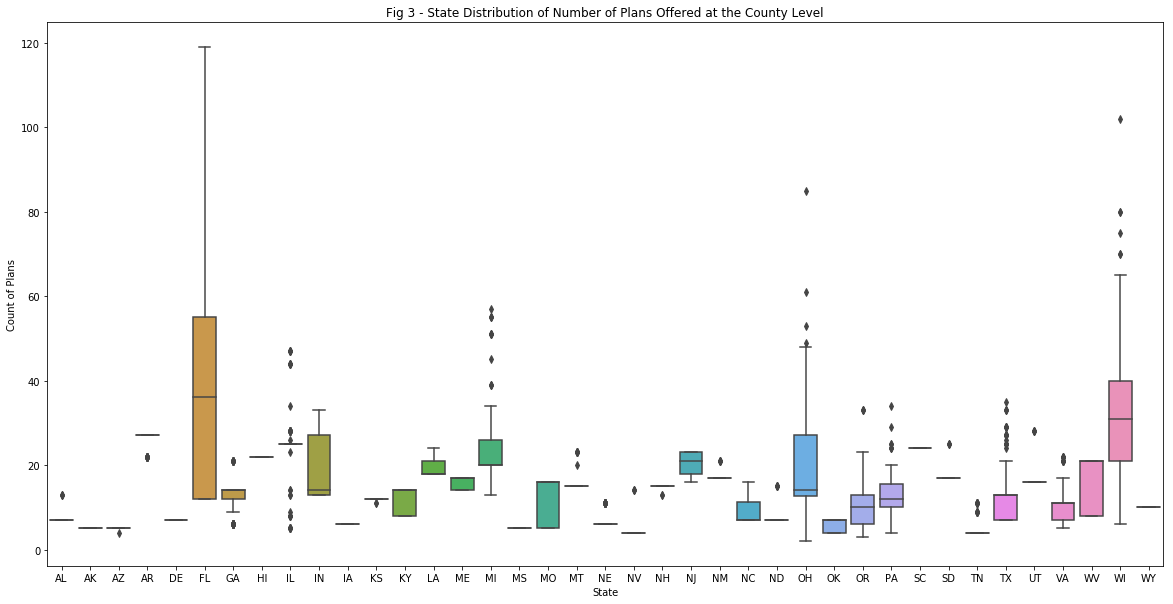

<Figure size 432x288 with 0 Axes>

In [12]:
# how many plans offered on each State - Distribution
plt.figure(figsize=(20,10))
_ = sns.boxplot(x='st', y='count_plans', data=plans_ahrf) 
# may be sort by state population size or color by it. 
_ = plt.title("Fig 3 - State Distribution of Number of Plans Offered at the County Level")
_ = plt.ylabel("Count of Plans")
_ = plt.xlabel("State")
plt.show()
plt.savefig("figure 3.png")

In [8]:
state_medplans = plans_ahrf.groupby('st')['count_plans'].median()
print(state_medplans.min())
print(state_medplans.max())
print(plans_ahrf.groupby('state')['count_plans'].max().sort_values().head(10))



4
36
state
Alaska          5
Arizona         5
Mississippi     5
Iowa            6
Delaware        7
Oklahoma        7
Wyoming        10
Tennessee      11
Nebraska       11
Kansas         12
Name: count_plans, dtype: int64


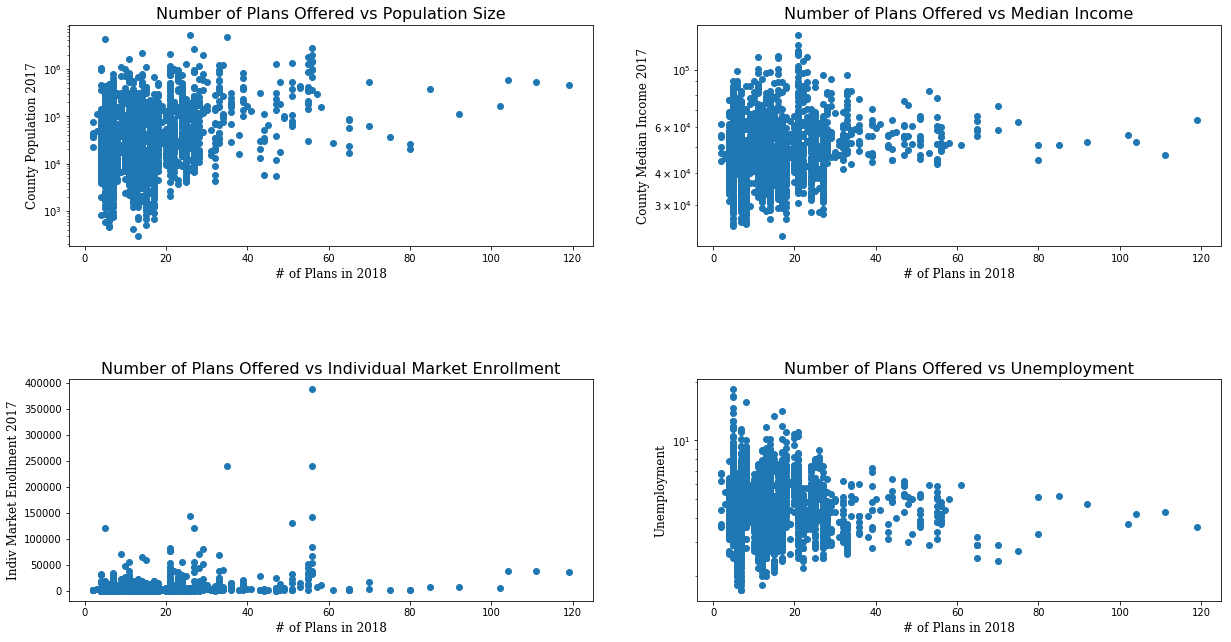

<Figure size 432x288 with 0 Axes>

In [13]:
plt.figure(figsize=(20,10))

plt.subplot(221)
_ = plt.scatter(x = plans_ahrf['count_plans'], y = plans_ahrf['Pop2017'])
_ = plt.yscale('log')
_ = plt.xlabel("# of Plans in 2018",fontdict=font)
_ = plt.ylabel("County Population 2017",fontdict=font)
_ = plt.title("Number of Plans Offered vs Population Size", fontsize=16)

plt.subplot(222)
_ = plt.scatter(x = plans_ahrf['count_plans'], y = plans_ahrf['MedIncome2017'])
_ = plt.yscale('log')
_ = plt.xlabel("# of Plans in 2018",fontdict=font)
_ = plt.ylabel("County Median Income 2017",fontdict=font)
_ = plt.title("Number of Plans Offered vs Median Income", fontsize=16)

plt.subplot(223)
_ = plt.scatter(x = plans_ahrf['count_plans'], y = plans_ahrf['IndMarketEnroll2017'])
_ = plt.xlabel("# of Plans in 2018",fontdict=font)
_ = plt.ylabel("Indiv Market Enollment 2017",fontdict=font)
#plt.yscale('log')
_ = plt.title("Number of Plans Offered vs Individual Market Enrollment", fontsize=16)

plt.subplot(224)
_ = plt.scatter(x = plans_ahrf['count_plans'], y = plans_ahrf['Unemployment'])
_ = plt.xlabel("# of Plans in 2018",fontdict=font)
_ = plt.ylabel("Unemployment",fontdict=font)
_ = plt.yscale('log')
_ = plt.title("Number of Plans Offered vs Unemployment", fontsize=16)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9 , hspace=.6)
plt.show()
plt.savefig("figure 4.png")

In [10]:
varsel = plans_ahrf[['count_plans','MedIncome2017','IndMarketEnroll2017','Pop2017','Unemployment']][plans_ahrf['Unemployment'].notnull()]
print(len(varsel))
print(varsel.corr())

2718
                     count_plans  MedIncome2017  IndMarketEnroll2017  \
count_plans             1.000000       0.129539             0.270887   
MedIncome2017           0.129539       1.000000             0.189244   
IndMarketEnroll2017     0.270887       0.189244             1.000000   
Pop2017                 0.252852       0.243056             0.845268   
Unemployment           -0.034369      -0.437464            -0.050406   

                      Pop2017  Unemployment  
count_plans          0.252852     -0.034369  
MedIncome2017        0.243056     -0.437464  
IndMarketEnroll2017  0.845268     -0.050406  
Pop2017              1.000000     -0.049248  
Unemployment        -0.049248      1.000000  
